# Where are my files?

In [96]:
! gsutil ls gs://rat-emotion/report/training-times_2020-07-24/

gs://rat-emotion/report/training-times_2020-07-24/carleton-colab-time-compare.png
gs://rat-emotion/report/training-times_2020-07-24/carleton-log.txt
gs://rat-emotion/report/training-times_2020-07-24/colab-log.txt


# What's inside the files?
Note this is just the tail. The files have headers that are different 

In [45]:
! gsutil cat -r -1000 gs://rat-emotion/report/training-times_2020-07-24/carleton-log.txt

 loss: 0.0008 lr: 0.001
2020-07-24 14:12:58 iteration: 795000 loss: 0.0008 lr: 0.001
2020-07-24 14:14:17 iteration: 796000 loss: 0.0008 lr: 0.001
2020-07-24 14:15:36 iteration: 797000 loss: 0.0008 lr: 0.001
2020-07-24 14:16:53 iteration: 798000 loss: 0.0008 lr: 0.001
2020-07-24 14:18:12 iteration: 799000 loss: 0.0008 lr: 0.001
2020-07-24 14:19:30 iteration: 800000 loss: 0.0008 lr: 0.001
2020-07-24 14:20:49 iteration: 801000 loss: 0.0008 lr: 0.001
2020-07-24 14:22:07 iteration: 802000 loss: 0.0008 lr: 0.001
2020-07-24 14:23:27 iteration: 803000 loss: 0.0008 lr: 0.001
2020-07-24 14:24:45 iteration: 804000 loss: 0.0008 lr: 0.001
2020-07-24 14:26:03 iteration: 805000 loss: 0.0008 lr: 0.001
2020-07-24 14:27:23 iteration: 806000 loss: 0.0008 lr: 0.001
2020-07-24 14:28:41 iteration: 807000 loss: 0.0008 lr: 0.001
2020-07-24 14:29:59 iteration: 808000 loss: 0.0008 lr: 0.001
2020-07-24 14:31:17 iteration: 809000 loss: 0.0008 lr: 0.001
2020-07-24 14:32:36 iteration: 810000 loss: 0.0008 lr: 0.001


In [42]:
import re
import time
import datetime
import pandas as pd

s = '2020-07-24 14:20:49 iteration: 801000 loss: 0.0008 lr: 0.001'

match = re.match('(?P<date>\d+\-\d+\-\d+\s\d+\:\d+\:\d+)\s.*', s)
t = time.strptime(match.group(1), '%Y-%m-%d %H:%M:%S')

datetime.datetime(*time)

1595600449.0

In [29]:
import tempfile
import os
import matplotlib.pyplot as plt
import re
import time

from pathlib import Path
n_cutoff = 1e3

def parse_file(filepath, max_rows=150):
    pattern = '(?P<date>\d+\-\d+\-\d+\s\d+\:\d+\:\d+)\s.*'
    out = []
    
    with open(filepath, 'r') as fp:
        for row in fp:
            if len(out) > max_rows:
                break
                
            match = re.match(pattern, row)
            if not match: continue
            
            t = time.strptime(match.group(1), '%Y-%m-%d %H:%M:%S')
            out.append(time.mktime(t))
            
    return pd.Series(out)
    
with tempfile.TemporaryDirectory() as tempdir:
    tempdir_path = Path(tempdir)

    # Download log files to tempdir
    ! gsutil cp -r gs://rat-emotion/report/training-times_2020-07-24/* {tempdir}
    
    carleton_data = parse_file(tempdir_path / 'carleton-log.txt')
    colab_data = parse_file(tempdir_path / 'colab-log.txt')

Copying gs://rat-emotion/report/training-times_2020-07-24/carleton-log.txt...
Copying gs://rat-emotion/report/training-times_2020-07-24/colab-log.txt...      
/ [2 files][ 61.1 KiB/ 61.1 KiB]                                                
Operation completed over 2 objects/61.1 KiB.                                     


Copying file:///tmp/tmpp784uim6/carleton-colab-time-compare.png [Content-Type=image/png]...
/ [1 files][ 44.8 KiB/ 44.8 KiB]                                                
Operation completed over 1 objects/44.8 KiB.                                     


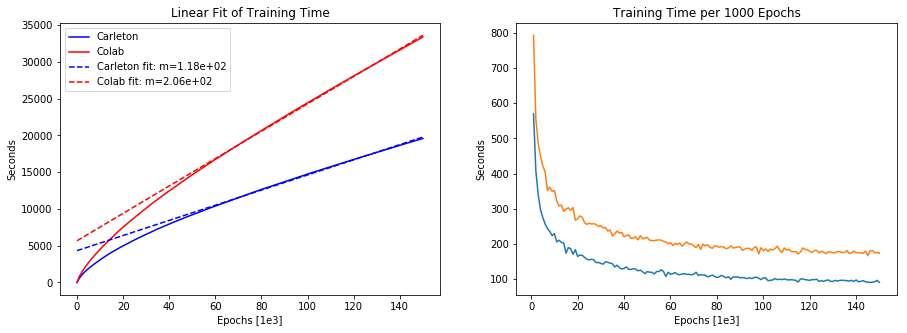

In [98]:
import numpy as np
import scipy
import pandas as pd
import tempfile
from pathlib import Path

plt.figure(figsize=(15,5))

# Plot Total Training Time
normalize = lambda s: s - s[0]
plt.subplot(1, 2, 1)
plt.plot(normalize(carleton_data), 'b')
plt.plot(normalize(colab_data), 'r')
plt.ylabel('Seconds')
plt.xlabel('Epochs [1e3]')

def makeline(s):
    a, b = linfit(s, 50)
    return a * np.arange(s.shape[0]) + b

def linfit(s, offset=0):
    s = normalize(s.copy())
    return np.polyfit(np.arange(start=offset, stop=s.shape[0]), s.iloc[offset:].values, 1)

plt.plot(makeline(carleton_data), 'b--')
plt.plot(makeline(colab_data), 'r--')
plt.legend([
    'Carleton',
    'Colab',
    'Carleton fit: m={:<.3}'.format(linfit(carleton_data)[0], 50),
    'Colab fit: m={:<.3}'.format(linfit(colab_data)[0], 50)
])
plt.title('Linear Fit of Training Time')

# Plot Training Time per 1000 Epochs
get_deltas = lambda s: s - s.shift()
plt.subplot(1, 2, 2)
plt.plot(get_deltas(carleton_data))
plt.plot(get_deltas(colab_data))
plt.ylabel('Seconds')
plt.xlabel('Epochs [1e3]')
plt.title('Training Time per 1000 Epochs')

with tempfile.TemporaryDirectory() as tempdir:
    save_path = str(Path(tempdir) / 'carleton-colab-time-compare.png')
    plt.savefig(save_path, bbox_inches='tight')
    ! gsutil cp {save_path} gs://rat-emotion/report/training-times_2020-07-24/